In [1]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
COCO_dataset = os.path.join(BASE_DIR, "COCO_dataset")
MPII_dataset = os.path.join(BASE_DIR, "MPII_dataset")
IMG_DIR = os.path.join(MPII_dataset, "images")
MPII_annotation = os.path.join(MPII_dataset, "updated_mpii_dataset.csv")
TEMP_DIMENSION = (100, 100)
OUTPUT_DIMENSION = (320, 320)

In [3]:
pd_data = pd.read_csv(MPII_annotation)
for i in pd_data.columns[1:-7]:
    pd_data[i] = pd_data[i].apply(literal_eval)
pd_data

,image_name,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,pelvis,thorax,upper_neck,head_top,scale,activity,category
0,015601864.jpg,"(692, 185)","(601, 167)","(693, 240)","(553, 161)","(688, 313)","(606, 217)","(647, 188)","(573, 185)","(661, 221)","(616, 269)","(656, 231)","(620, 394)","(610, 187)","(647, 176)","(637.0201, 189.8183)","(695.9799, 108.1817)",3.021046,curling,sports
1,015599452.jpg,"(719, 299)","(647, 281)","(711, 516)","(555, 410)","(545, 466)","(563, 296)","(720, 593)","(806, 543)","(-1, -1)","(-1, -1)","(-1, -1)","(-1, -1)","(763, 568)","(683, 290)","(682.0, 256.0)","(676.0, 68.0)",5.641276,curling,sports
2,005808361.jpg,"(1067, 253)","(902, 253)","(1167, 353)","(798, 340)","(1142, 478)","(869, 214)","(1040, 454)","(908, 438)","(906, 528)","(816, 510)","(883, 707)","(804, 711)","(974, 446)","(985, 253)","(982.7591, 235.9694)","(962.2409, 80.0306)",4.718488,curling,sports
3,086617615.jpg,"(314, 264)","(244, 261)","(327, 320)","(260, 335)","(362, 346)","(328, 354)","(294, 342)","(201, 340)","(335, 370)","(305, 375)","(331, 455)","(301, 461)","(248, 341)","(279, 263)","(277.021, 268.7786)","(305.979, 184.2214)",2.681349,curling,sports
4,060111501.jpg,"(923, 123)","(792, 147)","(995, 163)","(754, 247)","(961, 223)","(772, 294)","(943, 226)","(865, 248)","(948, 290)","(896, 318)","(881, 349)","(980, 322)","(904, 237)","(858, 135)","(871.1877, 180.4244)","(835.8123, 58.5756)",3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17367,033474347.jpg,"(663, 223)","(704, 214)","(674, 286)","(726, 260)","(631, 260)","(693, 243)","(742, 303)","(779, 296)","(706, 386)","(815, 380)","(739, 468)","(876, 461)","(761, 300)","(684, 219)","(671.7848, 204.2324)","(629.2152, 152.7676)",2.003677,pushing car,transportation
17368,082650067.jpg,"(729, 220)","(821, 204)","(704, 332)","(864, 273)","(675, 269)","(815, 236)","(831, 337)","(903, 328)","(811, 504)","(950, 504)","(853, 637)","(1038, 656)","(867, 333)","(775, 212)","(762.9653, 196.7913)","(696.0347, 112.2087)",3.235820,pushing car,transportation
17369,072772110.jpg,"(490, 378)","(572, 377)","(470, 411)","(565, 393)","(461, 414)","(558, 411)","(511, 458)","(553, 452)","(529, 536)","(558, 539)","(541, 610)","(562, 617)","(532, 455)","(531, 378)","(528.9869, 352.8365)","(525.0131, 303.1635)",1.494952,pushing car,transportation
17370,039361034.jpg,"(466, 251)","(441, 253)","(436, 293)","(404, 288)","(410, 325)","(378, 311)","(540, 280)","(510, 278)","(558, 331)","(466, 322)","(596, 368)","(496, 377)","(525, 279)","(454, 252)","(451.3169, 251.4431)","(403.6831, 241.5569)",1.459468,pushing car,transportation


In [4]:
def get_line_segments(x):
    groups = [
        ["left_shoulder", "left_elbow"],
        ["left_elbow", "left_wrist"],
        ["right_shoulder", "right_elbow"],
        ["right_elbow", "right_wrist"],
        ["left_ankle", "left_knee"],
        ["left_knee", "left_hip"],
        ["right_ankle", "right_knee"],
        ["right_knee", "right_hip"],
        ["left_shoulder", "right_shoulder"],
        ["left_hip", "right_hip"]
    ]
    
    lines = []
    for i in groups:
        if x[i[0]][0] != -1 and x[i[1]][0] != -1:
            lines.append([x[i[0]], x[i[1]]])
    if x[groups[-2][0]][0] != -1 and x[groups[-2][1]][0] != -1:
        if x[groups[-1][0]][0] != -1 and x[groups[-1][1]][0] != -1:
            lines.append([
                [(x[groups[-2][0]][0] + x[groups[-2][1]][0])/2, (x[groups[-2][0]][1] + x[groups[-2][1]][1])/2],
                [(x[groups[-1][0]][0] + x[groups[-1][1]][0])/2, (x[groups[-1][0]][1] + x[groups[-1][1]][1])/2]
            ])
    return lines

In [5]:
def adjust_offset(x, coordinates="x", offset=0):
    if coordinates == "x":
        for i in range(1,x.size-3):
            if x[i][0] != -1:
                x[i] = [x[i][0] - offset, x[i][1]]
    else:
        for i in range(1,x.size-3):
            if x[i][0] != -1:
                x[i] = [x[i][0], x[i][1] - offset]
    return x

In [6]:
def resize(x, scale):
    for i in range(1,x.size-3):
        if x[i][0] != -1:
            x[i] = [int(x[i][0]/scale), int(x[i][1]/scale)]
    return x

In [7]:
def read_image(img_loc: str, channel: "gray or rgb"="gray"):
    channel = channel.lower()
    assert channel in ["gray", "rgb"]
    image = cv2.imread(img_loc)
    if channel == "rgb":
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)
        height, width, channel = image.shape
    return image

In [8]:
def display_image(image: "image_loc or numpy.ndarray", ratio:int=5, **kwargs):
    assert isinstance(image, str) or isinstance(image, np.ndarray)
    channel = kwargs.get("channel", "gray")
    if isinstance(image, str):
        image = read_image(image, channel)
    else:
        if channel == "gray": image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert isinstance(image, np.ndarray)
    height, width = image.shape[0], image.shape[1]
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(ratio*aspect_ratio, ratio))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')
    cmap = channel if channel == "gray" else "viridis"
    ax.imshow(image, cmap=cmap)
    return ax

In [9]:
def display_image_with_pose(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", ratio:int=5, **kwargs):
    ax = display_image(image, ratio, **kwargs)
    line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
    ax.add_collection(line_segments)
    temp = pose.apply(lambda x: get_line_segments(x), axis=1).to_list()[0]
    dots = list(set((j[0], j[1]) for i in temp for j in i))
    line_segments.set_segments(temp)
    for i in dots:
        plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    return ax

### For image cropping, we are always cropping along the width of the image and not the height

In [ ]:
def crop_image(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", **kwargs):
    assert isinstance(image, str) or isinstance(image, np.ndarray)
    channel = kwargs.get("channel", "gray")
    if isinstance(image, str):
        image = read_image(image, channel)
    else:
        if channel == "gray": image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    width, height = image.shape[1], image.shape[0]
    # Make sure that the image width is at least equal to image height, else add padding to the right
    if width < height:
        image = cv2.copyMakeBorder(image, 0, 0, 0, height - width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    min_x, min_y, max_x, max_y = width, height, 0, 0
    # for i in pose.values[0][1:-7]:
    for i in pose[1:-7]:
        if i[0] != -1:
            min_x, min_y = min(min_x, i[0]), min(min_y, i[1])
            max_x, max_y = max(max_x, i[0]), max(max_y, i[1])
    center_x, center_y = int((min_x+max_x)/2), int((min_y+max_y)/2)
    annot_width, annot_height = max_x - min_x, max_y - min_y
    # If the annotation height or width is greater than image height or width,
    # add padding to the image and crop afterwards
    if annot_height > width:
        padding = (annot_height - width)//2
        image = cv2.copyMakeBorder(image, 0, 0, padding, annot_height - width - padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        pose[1:-7] = pose[1:-7].apply(adjust_offset, args=(x, coordinates="x", offset=-padding))
    if annot_width > height:
        padding = (annot_width - height)//2
        image = cv2.copyMakeBorder(image, padding, annot_width - height - padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates="y", offset=-padding), axis=1)
        pose[1:-7] = pose[1:-7].apply(adjust_offset, args=(x, coordinates="y", offset=-padding))
    width, height = image.shape[1], image.shape[0]
    if height < width:
        # height stays the same, crop the width
        offset = max(0, center_x - int(height/2))
        adj_coor = "x"
        image = image[:, offset: offset + height]
        pose[1:-7] = pose[1:-7].apply(adjust_offset, args=(x, coordinates=adj_coor, offset=offset))
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates=adj_coor, offset=offset), axis=1)
    if width < height:
        # width stays the same, crop the height
        offset = max(0, center_y - int(width/2))
        adj_coor = "y"
        image = image[offset: offset + width, :]
#         pose = pose.apply(lambda x: adjust_offset(x, coordinates=adj_coor, offset=offset), axis=1)
        pose[1:-7] = pose[1:-7].apply(adjust_offset, args=(x, coordinates=adj_coor, offset=offset))
    if image.shape[1] < image.shape[0]: # pad to the right
        image = cv2.copyMakeBorder(image, 0, 0, 0, image.shape[0] - image.shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])
    if image.shape[0] < image.shape[1]: # pad to the bottom
        image = cv2.copyMakeBorder(image, 0, image.shape[1] - image.shape[0], 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    if kwargs.get("display"):
        ax = display_image(image, **kwargs)
        line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
        ax.add_collection(line_segments)
        temp = pose.copy()
        temp[1:-7] = temp[1:-7].apply(get_line_segments(x))
        temp = temp.to_list()[0]
#         temp = pose.apply(lambda x: get_line_segments(x), axis=1).to_list()[0]
        dots = list(set((j[0], j[1]) for i in temp for j in i))
        line_segments.set_segments(temp)
        for i in dots:
            plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    return image, pose

In [11]:
def resize_image(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", dimensions: tuple, **kwargs):
    print(image.shape)
    scale = image.shape[0]/dimensions[0]
    assert isinstance(dimensions, tuple) and len(dimensions) == 2
    image = cv2.resize(image, dimensions, interpolation=cv2.INTER_AREA)
    pose = pose.apply(lambda x: resize(x, scale=scale), axis=1)
    return image, pose

In [12]:
idx = 12310
img_loc = os.path.join(IMG_DIR, pd_data.iloc[idx]['image_name'])
print(img_loc, "\n")
pd_data.iloc[[idx]]

/home/pratik/Downloads/Documents/Human Pose Estimation/MPII_dataset/images/095068194.jpg 



,image_name,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,pelvis,thorax,upper_neck,head_top,scale,activity,category
12310,095068194.jpg,"(785, 396)","(866, 347)","(679, 326)","(872, 309)","(628, 235)","(887, 216)","(662, 448)","(702, 405)","(627, 295)","(686, 349)","(482, 287)","(613, 428)","(682, 427)","(826, 372)","(825.4605, 345.5646)","(823.5395, 251.4354)",2.824465,rock climbing,sports


In [13]:
temp = pd_data.iloc[[12310]].copy()
temp

,image_name,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,pelvis,thorax,upper_neck,head_top,scale,activity,category
12310,095068194.jpg,"(785, 396)","(866, 347)","(679, 326)","(872, 309)","(628, 235)","(887, 216)","(662, 448)","(702, 405)","(627, 295)","(686, 349)","(482, 287)","(613, 428)","(682, 427)","(826, 372)","(825.4605, 345.5646)","(823.5395, 251.4354)",2.824465,rock climbing,sports


In [14]:
idx = 12310
x = pd_data.iloc[12310]
img_loc = os.path.join(IMG_DIR, x['image_name'])
print(img_loc)
new_loc = "{0}/updated/{1}/{2}".format("/".join(img_loc.split("/")[:-2]), x.name//100, img_loc.split("/")[-1])
DIR = "/".join(new_loc.split("/")[:-1])
print(new_loc)
print(DIR)

/home/pratik/Downloads/Documents/Human Pose Estimation/MPII_dataset/images/095068194.jpg
/home/pratik/Downloads/Documents/Human Pose Estimation/MPII_dataset/updated/123/095068194.jpg
/home/pratik/Downloads/Documents/Human Pose Estimation/MPII_dataset/updated/123


In [25]:
def move(x):
    return x[0]+5

In [26]:
def update_image(x):
    img_loc = os.path.join(IMG_DIR, x['image_name'])
    image = read_image(img_loc, channel="rgb")
    print(x)
    x[1:-7] = x[1:-7].apply(move)
    print(x)
#     print(x.apply(move))
#     print(x[1:-7].apply(move))
#     image, x = crop_image(image, pose=x, channel="rgb")
#     print(image.shape)
#     image, x = resize_image(image, pose=x, dimensions=TEMP_DIMENSION)
#     print(image.shape)
#     image, x = resize_image(image, pose=x, dimensions=OUTPUT_DIMENSION)
#     print(image.shape)
#     new_loc = "{0}/updated/{1}/{2}".format("/".join(img_loc.split("/")[:-2]), x.name//100, img_loc.split("/")[-1])
#     temp_dir = "/".join(new_loc.split("/")[:-1])
#     if not os.path.exists(temp_dir): os.makedirs(temp_dir)
#     cv2.imwrite(new_loc, image)
    return x

In [27]:
temp.apply(lambda x: update_image(x), axis=1)

image_name               095068194.jpg
left_shoulder               (785, 396)
right_shoulder              (866, 347)
left_elbow                  (679, 326)
right_elbow                 (872, 309)
left_wrist                  (628, 235)
right_wrist                 (887, 216)
left_hip                    (662, 448)
right_hip                   (702, 405)
left_knee                   (627, 295)
right_knee                  (686, 349)
left_ankle                  (482, 287)
right_ankle                 (613, 428)
pelvis                      (682, 427)
thorax                      (826, 372)
upper_neck        (825.4605, 345.5646)
head_top          (823.5395, 251.4354)
scale                         2.824465
activity                 rock climbing
category                        sports
Name: 12310, dtype: object
image_name               095068194.jpg
left_shoulder                      790
right_shoulder                     871
left_elbow                         684
right_elbow                        87

,image_name,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,pelvis,thorax,upper_neck,head_top,scale,activity,category
12310,095068194.jpg,790,871,684,877,633,892,667,707,632,691,487,618,"(682, 427)","(826, 372)","(825.4605, 345.5646)","(823.5395, 251.4354)",2.824465,rock climbing,sports


In [385]:
pbar = tqdm(total=pd_data.shape[0], desc="Asserting equal image height and width")
for idx in range(pd_data.shape[0]):
    img_loc = os.path.join(IMG_DIR, pd_data.iloc[idx]['image_name'])
    pose_loc = pd_data.iloc[[idx]]
    img, new_data = crop_image(img_loc, pose=pose_loc, display=False)
    assert img.shape[0] == img.shape[1]
    pbar.update(1)
pbar.close()

Asserting equal image height and width:   0%|          | 0/17372 [00:00<?, ?it/s]

<AxesSubplot:>

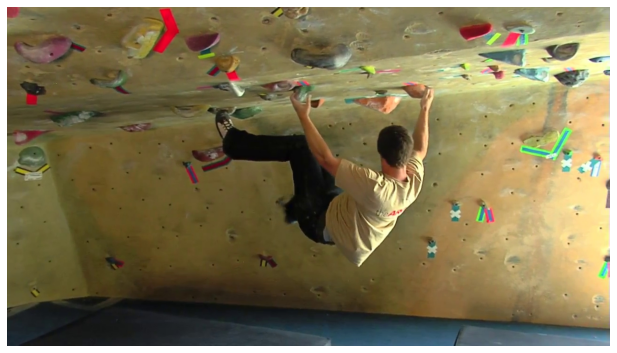

In [25]:
display_image(img_loc, channel="rgb")

<AxesSubplot:>

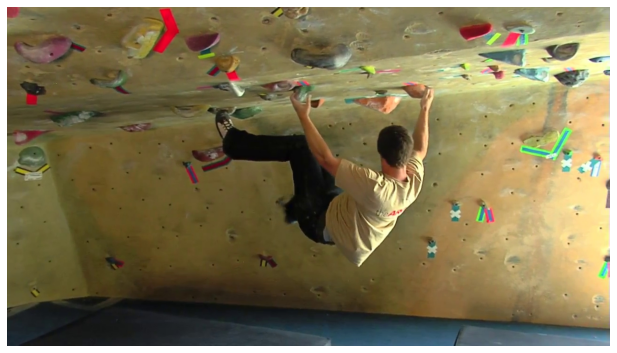

In [42]:
display_image(read_image(img_loc, channel="rgb"), channel="rgb")